# Pre-processing of ECG data for arrythmia detection

In [1]:
!pip install wfdb
!pip install biosppy

  Using cached wfdb-4.1.0-py3-none-any.whl (159 kB)
  Using cached soundfile-0.11.0-py2.py3-none-macosx_10_9_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
  Using cached biosppy-1.0.0-py2.py3-none-any.whl (106 kB)
  Using cached bidict-0.22.1-py3-none-any.whl (35 kB)
  Using cached shortuuid-1.0.11-py3-none-any.whl (10 kB)
  Using cached opencv_python-4.7.0.68-cp37-abi3-macosx_10_13_x86_64.whl (51.7 MB)


In [10]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wfdb as wf
import glob
from biosppy.signals import ecg
from wfdb import processing
import scipy
from scipy import *
from os import path

__Download MIT-BIH Dataset:__
1.	Download the zip file with raw data from: https://physionet.org/content/mitdb/1.0.0/ 
2.	Store data into a folder called ‘mitbih’.
3.	Access the folder from your notebook.
4.	Pre-process the data into a csv file to be used for your models.


__Data Preprocessing:__

* This data has been pre-annotated and labelled by cardiologists.
* These different annotations refer to various normal and abnormal ECG signals which represent different types of arrhythmia. 
* The dataset consists of ECG signals of various classes, but the eight classes used for this investigation are ’N’, ’L’, ’R’, ’V’, ’A’, ’F’, ’f’, ’/’. 
* The table shows the description and numerical identification values assigned to these classes.

__Extract data from the raw MIT-BIH files:__

* Each patient record included a complete set of heartbeats, so each individual beat was extracted from all the records.
* This is done by matching the R-peaks of the ECG with their respective annotation class and appending the class’ numerical value at the end of the beat. 
* To make every beat contain equal amount of data points, the R-peaks were centered and equal amount of datapoints were selected on both sides of the peak.
* This allowed us to maintain consistency for each beat. To avoid irregular amplitudes between signals.

__Generate the classifications based on the annotations:__

* 0.0 = undetermined
* 1.0 = normal
* 2.0 = LBBBB
* 3.0 = RBBBB
* 4.0 = Premature Ventricular contraction
* 5.0 = Atrial Premature beat
* 6.0 = Fusion ventricular normal beat
* 7.0 = Fusion of paced and normal beat
* 8.0 = paced beat

In [9]:
def extract_data():
    data_files = glob.glob('./mitbih/*.atr')
    data_files = [i[:-4] for i in data_files]
    data_files.sort()
    return data_files

length = 275
records = extract_data()
print('Total files: ', len(records))

good_beats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

for file_path in records:
    file_pathpts = file_path.split('/')
    fn = file_pathpts[-1]
    print('Loading file:', file_path)

    # Read in the data
    if path.exists(file_path+".hea"):
        record = wf.rdsamp(file_path)
        annotation = wf.rdann(file_path, 'atr')

        # Print some meta informations
        print('    Sampling frequency used for this record:', record[1].get('fs'))
        print('    Shape of loaded data array:', record[0].shape)
        print('    Number of loaded annotations:', len(annotation.num))

        # Get the ECG values from the file.
        data = record[0].transpose()

        clas = np.array(annotation.symbol)
        rate = np.zeros_like(clas, dtype='float')
        for clasid, clasval in enumerate(clas):
            if (clasval == 'N'):
                rate[clasid] = 1.0 # Normal
            elif (clasval == 'L'):
                rate[clasid] = 2.0 # LBBBB
            elif (clasval == 'R'):
                rate[clasid] = 3.0 # RBBBB
            elif (clasval == 'V'):
                rate[clasid] = 4.0 # Premature Ventricular contraction
            elif (clasval == 'A'):
                rate[clasid] = 5.0 # Atrial Premature beat
            elif (clasval == 'F'):
                rate[clasid] = 6.0 # Fusion ventricular normal beat
            elif (clasval == 'f'):
                rate[clasid] = 7.0 # Fusion of paced and normal beat
            elif (clasval == '/'):
                rate[clasid] = 8.0 # paced beat
            
        rates = np.zeros_like(data[0], dtype='float')
        rates[annotation.sample] = rate

        indices = np.arange(data[0].size, dtype='int')

        # Manipulate both channels
        for channelid, channel in enumerate(data):
            chname = record[1].get('sig_name')[channelid]
            print('    ECG channel type:', chname)

            # Find rpeaks in the ECG data. Most should match with
            # the annotations.
            out = ecg.ecg(signal=channel, sampling_rate=360, show=False)

            # Split into individual heartbeats. For each heartbeat
            # record, append classification.

            beats = []
            for ind, ind_val in enumerate(out['rpeaks']):

                start,end = ind_val-length//2, ind_val+length//2
                if start < 0:
                    start = 0
                diff = length - len(channel[start:end])
                if diff > 0:
                    padding = np.zeros(diff, dtype='float')
                    padded_channel = np.append(padding, channel[start:end])
                    beats.append(padded_channel)
                else:
                    beats.append(channel[start:end])

                # Get the classification value that is on
                # or near the position of the rpeak index.
                from_ind = 0 if ind_val < 10 else ind_val - 10
                to_ind = ind_val + 10
                clasval = rates[from_ind:to_ind].max()

                # Standardize the data
                beats[ind] = ((beats[ind] - np.mean(beats[ind])) / np.std(beats[ind]))

                # Append the classification to the beat data.
                beats[ind] = np.append(beats[ind], clasval)

                # Append the record number to the beat data.
                beats[ind] = np.append(beats[ind], fn[-3:])

            # Save to CSV file.
            savedata = np.array(beats[:], dtype=np.float)
            outfn = './'+fn+'_'+chname+'.csv'
            print('Generating ', outfn)
            with open(outfn, "wb") as fin:
                np.savetxt(fin, savedata, delimiter=",", fmt='%f')
    else:
        print('    ECG '+file_path+' not complete, skipping')

Total files:  49
Loading file: ./mitbih\100
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2274
    ECG channel type: MLII
Generating  ./mitbih\100_MLII.csv
    ECG channel type: V5
Generating  ./mitbih\100_V5.csv
Loading file: ./mitbih\101
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 1874
    ECG channel type: MLII
Generating  ./mitbih\101_MLII.csv
    ECG channel type: V1
Generating  ./mitbih\101_V1.csv
Loading file: ./mitbih\102
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2192
    ECG channel type: V5
Generating  ./mitbih\102_V5.csv
    ECG channel type: V2
Generating  ./mitbih\102_V2.csv
Loading file: ./mitbih\102-0
    ECG ./mitbih\102-0 not complete, skipping
Loading file: ./mitbih\103
    Sampling frequency used for this record: 360
    S

    ECG channel type: MLII
Generating  ./mitbih\208_MLII.csv
    ECG channel type: V1
Generating  ./mitbih\208_V1.csv
Loading file: ./mitbih\209
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 3052
    ECG channel type: MLII
Generating  ./mitbih\209_MLII.csv
    ECG channel type: V1
Generating  ./mitbih\209_V1.csv
Loading file: ./mitbih\210
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2685
    ECG channel type: MLII
Generating  ./mitbih\210_MLII.csv
    ECG channel type: V1
Generating  ./mitbih\210_V1.csv
Loading file: ./mitbih\212
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2763
    ECG channel type: MLII
Generating  ./mitbih\212_MLII.csv
    ECG channel type: V1
Generating  ./mitbih\212_V1.csv
Loading file: ./mitbih\213
    Sampling frequency u

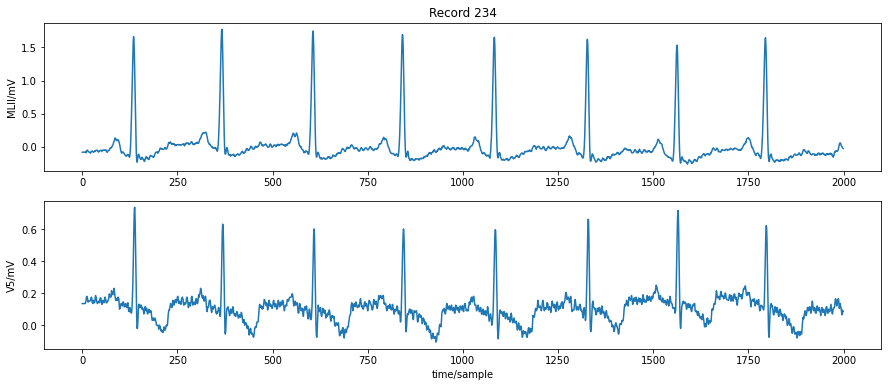

In [29]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6))
ax[0].plot(data[0, 0:2000])
ax[0].set_ylabel('MLII/mV')
ax[1].plot(data[1, 0:2000])
ax[1].set_ylabel('V5/mV')
ax[1].set_xlabel('time/sample')
ax[0].set_title('Record 234')
fig.savefig('ecg_data_unpreprocessed.jpg', dpi = 400)

In [33]:
# Combine all the pre-processed data:
new_len = 277
alldata = np.empty(shape=[0, new_len])
all_csv = glob.glob('./mitbih/*.csv')
for j in all_csv:
    csvrows = np.loadtxt(j, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)
print(alldata.shape)

(215361, 277)


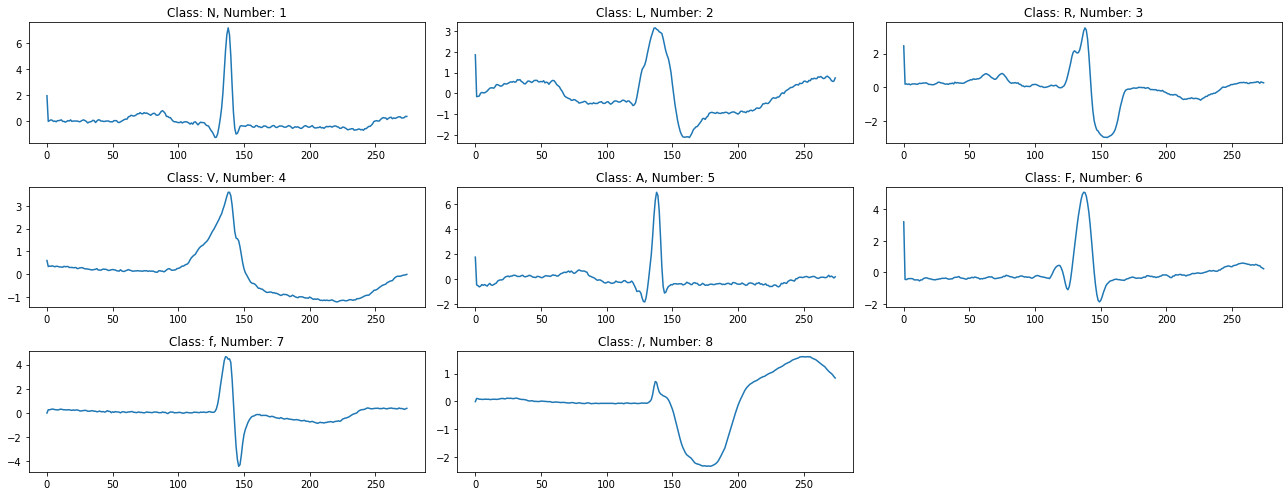

In [50]:
# Visualize the pre-processed data: 
fig, ax = plt.subplots(3, 3, figsize = (18, 7))
categories = ['N', 'L', 'R', 'V', 'A', 'F', 'f', '/']
for i in range(len(categories)):
    indices_category = np.argwhere(alldata[:, -2] == i + 1)
    ax[i // 3, i % 3].plot(np.arange(275), alldata[indices_category[5], :-2][0])
    ax[i // 3, i % 3].set_title('Class: ' + str(categories[i]) + ', Number: ' + str(i + 1))
ax[2, 2].axis('off')
plt.tight_layout()
fig.savefig('ecg_data_preprocessed.jpg', dpi = 400)

### Save all preprocessed data into one .csv file.

In [51]:
# Remove unidentified beats and save all data:
no_anno = np.where(alldata[:,-2]==0.0)[0]
print(no_anno.shape)
alldata = np.delete(alldata, no_anno,0)
print(alldata.shape)

with open('./all_data.csv', "wb") as fin:
    np.savetxt(fin, alldata, delimiter=",", fmt='%f')

(63909,)
(151452, 277)


dict_values([75052, 2546, 7130, 33, 7028, 982, 803, 229, 8075, 150, 83, 7259, 106, 2, 16])


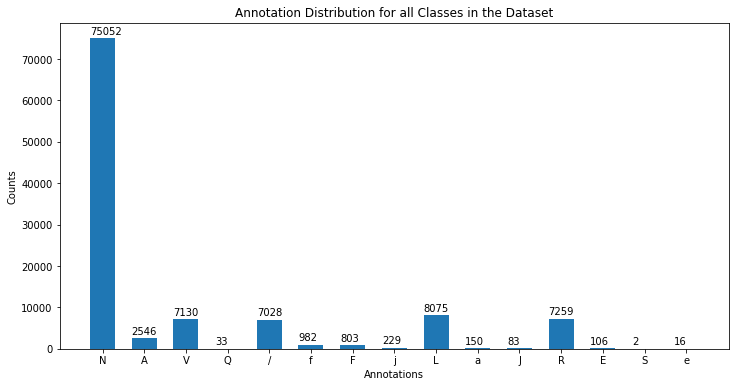

In [52]:
files = extract_data()
i = 0

good_beats =['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']
list_anns = []

for i in range(len(files)):
    datfile = files[i]
    
    if path.exists(datfile+".hea"):
        record = wf.rdsamp(datfile)
        ann = wf.rdann(datfile, 'atr')
        list_anns.extend(ann.symbol)

dict_anns = {}

for i in list_anns:
    dict_anns[i] = dict_anns.get(i,0)+1
    
dict_anns = {k:v for k,v in dict_anns.items() if k in good_beats}

print(dict_anns.values())

fig = plt.figure(figsize=(12,6))

xlocs, xlabs = plt.xticks()
barplt = plt.bar(list(dict_anns.keys()),dict_anns.values(),width = .6)
xlocs = [j for j in dict_anns.keys()]
ylabs = [j for j in dict_anns.values()]

plt.title('Annotation Distribution for all Classes in the Dataset')
plt.xlabel('Annotations')
plt.ylabel('Counts')

for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1000, yval)
    
plt.show()
fig.savefig('ecg_data_beats_per_class.jpg', dpi = 400)